## Wizualizacja danych: Projekt 2
## Jakie cechy dobrze różnicują firmy, które kontynuują działalność gospodarczą w okresie 12 miesięcy od tych, które działalności nie kontynuują?
[zmienna Target]

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("fivethirtyeight")
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

import lightgbm as lgb
from lightgbm import LGBMClassifier

import sys; sys.path.insert(0, '..')
from utils import evaluate

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [67]:
SAMPLE = 100_000

data = pd.read_csv("../data/ceidg_data_classif.csv")
if SAMPLE:
    data = data.sample(SAMPLE)
print(data.shape)

def convert_tak_nie_to_bool(x):
    converter = {
        "tak" : 1,
        "nie" : 0,
    }
    return x.map(converter)

def convert_sex(x):
    converter = {
        "M": 1,
        "F": 0
    }
    return x.map(converter)


### DATA PREPROCESSING

categorical_variables = ["MonthOfStartingOfTheBusiness", "MainAddressVoivodeship", "CorrespondenceAddressVoivodeship", "CorrespondenceAddressCounty", "PKDMainSection",  "Sex"]
numerical_variables = [
    "MainAndCorrespondenceAreTheSame", 
    "DurationOfExistenceInMonths", 
    "NoOfAdditionalPlaceOfTheBusiness",
    "IsPhoneNo",
    "IsEmail",
    "IsWWW",
#     "HasLicences",  # useless since we have NoOfLicenses
    "NoOfLicences",
    "HasPolishCitizenship",
    "ShareholderInOtherCompanies"
]

data["CommunityProperty"] = convert_tak_nie_to_bool(data["CommunityProperty"])

for col in categorical_variables:
    data[col] = data[col].astype('category')

x_train, x_test, y_train, y_test = train_test_split(data.drop("Target", axis=1), data["Target"], random_state=RANDOM_SEED)
x_train.head()

(2401055, 30)


,RandomDate,MonthOfStartingOfTheBusiness,QuarterOfStartingOfTheBusiness,MainAddressVoivodeship,MainAddressCounty,MainAddressTERC,CorrespondenceAddressVoivodeship,CorrespondenceAddressCounty,CorrespondenceAddressTERC,MainAndCorrespondenceAreTheSame,...,HasPolishCitizenship,ShareholderInOtherCompanies,PKDMainSection,PKDMainDivision,PKDMainGroup,PKDMainClass,NoOfUniquePKDSections,NoOfUniquePKDDivsions,NoOfUniquePKDGroups,NoOfUniquePKDClasses
1945399,2018-06-01,January,1,KUJAWSKO-POMORSKIE,GRUDZIąDZ,462011.0,KUJAWSKO-POMORSKIE,GRUDZIąDZ,462011.0,True,...,True,False,E,38.0,383.0,3832.0,5,8,8,10
365626,2018-09-29,February,1,LUBELSKIE,CHEłM,662011.0,LUBELSKIE,CHEłM,662011.0,True,...,True,False,G,45.0,451.0,4511.0,1,1,1,1
592516,2017-12-04,May,2,POMORSKIE,GDAńSKI,2204011.0,POMORSKIE,GDAńSKI,2204011.0,True,...,True,False,G,47.0,472.0,4721.0,1,1,3,4
1081769,2018-07-04,September,3,WIELKOPOLSKIE,LESZNO,3063011.0,WIELKOPOLSKIE,LESZNO,3063011.0,True,...,True,False,G,47.0,478.0,4782.0,1,1,2,4
1380143,2018-03-23,May,2,MAZOWIECKIE,OSTROłęCKI,1415085.0,MAZOWIECKIE,OSTROłęCKI,1415085.0,True,...,True,False,G,46.0,464.0,4642.0,1,1,1,1


In [84]:
x_train[model_columns].head()

,MonthOfStartingOfTheBusiness,MainAddressVoivodeship,CorrespondenceAddressVoivodeship,CorrespondenceAddressCounty,PKDMainSection,Sex,MainAndCorrespondenceAreTheSame,DurationOfExistenceInMonths,NoOfAdditionalPlaceOfTheBusiness,IsPhoneNo,IsEmail,IsWWW,NoOfLicences,HasPolishCitizenship,ShareholderInOtherCompanies
1945399,January,KUJAWSKO-POMORSKIE,KUJAWSKO-POMORSKIE,GRUDZIąDZ,E,F,True,149,1,False,True,False,1,True,False
365626,February,LUBELSKIE,LUBELSKIE,CHEłM,G,M,True,163,1,False,False,False,0,True,False
592516,May,POMORSKIE,POMORSKIE,GDAńSKI,G,F,True,79,0,False,False,False,0,True,False
1081769,September,WIELKOPOLSKIE,WIELKOPOLSKIE,LESZNO,G,F,True,154,4,False,False,False,0,True,False
1380143,May,MAZOWIECKIE,MAZOWIECKIE,OSTROłęCKI,G,M,True,262,2,False,True,False,0,True,False


In [102]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'max_depth': 6, 
    'learning_rate': 0.1,
    'verbose': 0}
n_estimators = 100

model_columns = categorical_variables + numerical_variables
x_train = x_train[model_columns]
x_test = x_test[model_columns]

d_train = lgb.Dataset(x_train, label=y_train)
d_test = lgb.Dataset(x_test, label=y_test)

clf = LGBMClassifier(max_depth=100, n_estimators=1000)
clf.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=100,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Accuracy: 82.89
F-1 score: 0.0587


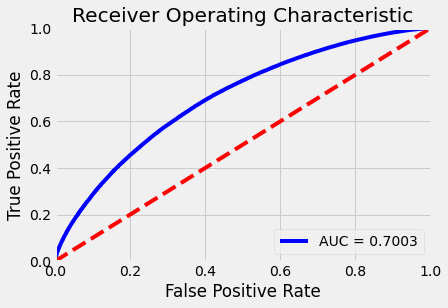

0.7003205402541218

In [103]:
evaluate(clf, x_test, y_test)

In [104]:
y_pred = clf.predict(x_test)
confusion_matrix(y_test, y_pred)

array([[494330,   2469],
       [100260,   3205]])

---
#### What features are important?

In [105]:
def get_transformer_feature_names(columnTransformer):

    output_features = []

    for name, pipe, features in columnTransformer.transformers_:
        if name != 'remainder':
            for i in pipe:
                trans_features = []
                if hasattr(i, 'categories_'):
                    trans_features.extend(i.get_feature_names(features))
                else:
                    trans_features = features
            output_features.extend(trans_features)

    return output_features

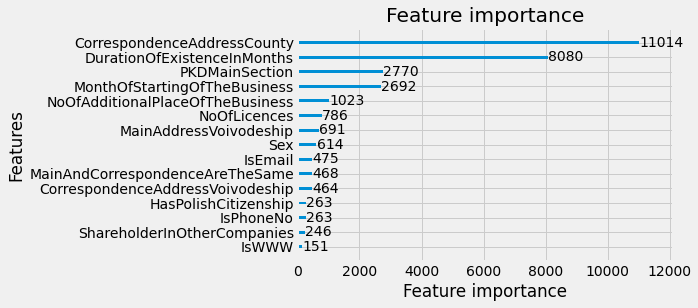

In [106]:
lgb.plot_importance(clf)